<a href="https://colab.research.google.com/github/la-becca/Alura/blob/main/Apache_Spark_Com_Python/Spark_PLN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Sessão e leitura dos dados**

In [1]:
# Instalando o PySpark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285388 sha256=3bd0f0169c080457f1208ec886392512ad2784307644ecb79bd78b20b5fd2276
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [2]:
# Iniciando uma sessão
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("analise_nlp") \
    .getOrCreate()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# baixando o kaggle: https://www.kaggle.com/datasets/luisfredgs/imdb-ptbr
# Leitura dos dados:
# 1. Pela conexão com o google drive
#2. Pelo carregamento no colab.(<---)
dados = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/Spark_PLN/imdb-reviews-pt-br.csv",
                       escape="\"",
                       header=True,
                       inferSchema=True)

### **Explorando os dados**



In [5]:
#Tamanho dos dados

print(f'Número de linhas: {dados.count()}')
print(f'Número de colunas: {len(dados.columns)}')

Número de linhas: 49459
Número de colunas: 4


In [6]:
#Colunas e tipos

dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [7]:
#Conteudo

dados.show(5, truncate=True)

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
+---+--------------------+--------------------+---------+
only showing top 5 rows



In [8]:
#Apresentando comentários negativos e positivos

print('Negativo')
dados.filter(dados.id == 190).select('text_pt').show(truncate = False)

print('Positivo')
dados.filter(dados.id == 12427).select('text_pt').show(truncate = False)

Negativo
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                 

In [9]:
#Contabilizandos os tipos de comentários

dados.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



### **Limpeza e processamento dos dados**

In [10]:
dados.show(10)

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
+---+--------------------+--------------------+---------+
only showing top 10 rows



#### WorldCloud

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [12]:
amostra = dados.select('text_pt').sample(fraction = 0.1, seed = 101)
tudo = [texto['text_pt'] for texto in amostra.collect()]

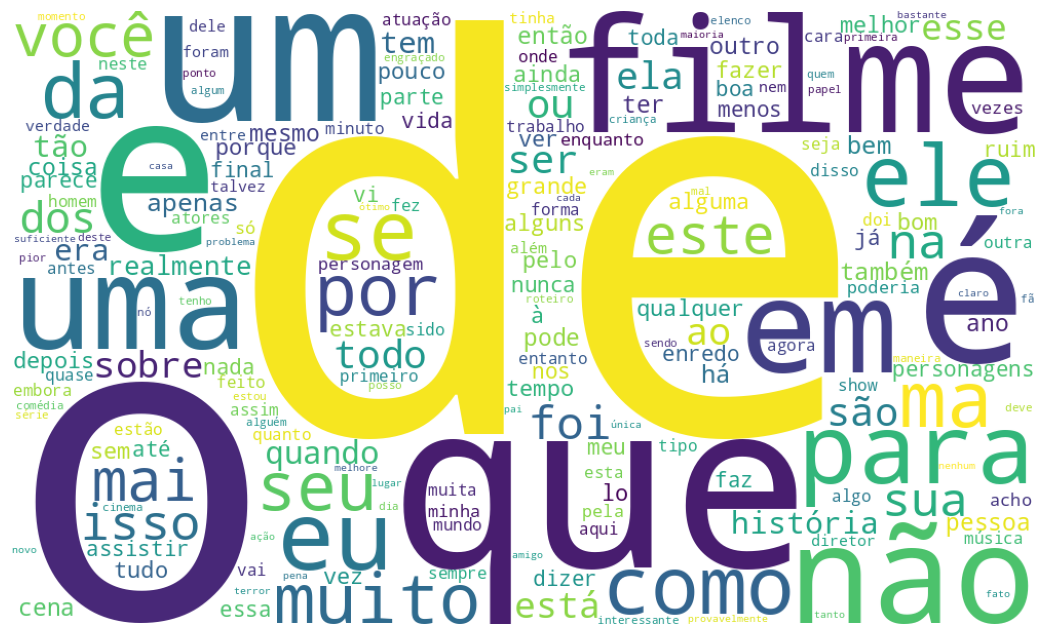

In [13]:
wordcloud = WordCloud(
    background_color= 'white',
    collocations = False,
    prefer_horizontal=1,
    width = 1000,
    height = 600,
).generate(str(tudo))

plt.figure(figsize=(20, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Limpeza

In [14]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
import pyspark.sql.functions as f

In [16]:
#Retirando caracteres especiais

dados = dados.withColumn('texto_regex', f.regexp_replace('text_pt', "[\$#,\"!%&'()*+-./:;<=>?@^_`´{|}~\\\\]", ""))

In [17]:
dados.show(5, truncate = False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [18]:
#Retirando espaço em branco

dados = dados.withColumn('texto_limpo', f.trim('texto_regex'))

In [19]:
dados.show(5, truncate = False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Tokenização

In [20]:
from pyspark.ml.feature import Tokenizer

In [21]:
tokenizer = Tokenizer(inputCol = 'texto_limpo', outputCol = 'tokens')
tokenizado = tokenizer.transform(dados)

In [22]:
tokenizado.select('texto_limpo', 'tokens').show(5)

+--------------------+--------------------+
|         texto_limpo|              tokens|
+--------------------+--------------------+
|Mais uma vez o Sr...|[mais, uma, vez, ...|
|Este é um exemplo...|[este, é, um, exe...|
|Primeiro de tudo ...|[primeiro, de, tu...|
|Nem mesmo os Beat...|[nem, mesmo, os, ...|
|Filmes de fotos d...|[filmes, de, foto...|
+--------------------+--------------------+
only showing top 5 rows



In [23]:
from pyspark.sql.types import IntegerType
countTokens = f.udf(lambda tokens: len(tokens), IntegerType())
tokenizado.select('texto_limpo', 'tokens')\
          .withColumn('Freq_tokens', countTokens(f.col('tokens')))\
          .show(5)

+--------------------+--------------------+-----------+
|         texto_limpo|              tokens|Freq_tokens|
+--------------------+--------------------+-----------+
|Mais uma vez o Sr...|[mais, uma, vez, ...|        168|
|Este é um exemplo...|[este, é, um, exe...|        245|
|Primeiro de tudo ...|[primeiro, de, tu...|        213|
|Nem mesmo os Beat...|[nem, mesmo, os, ...|        324|
|Filmes de fotos d...|[filmes, de, foto...|        244|
+--------------------+--------------------+-----------+
only showing top 5 rows



#### StopWords

In [24]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_A = stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [25]:
from pyspark.ml.feature import StopWordsRemover

stop_B = StopWordsRemover.loadDefaultStopWords('portuguese')

In [26]:
remover = StopWordsRemover(inputCol='tokens', outputCol='texto_final', stopWords=stop_A)

In [27]:
feature_data = remover.transform(tokenizado)

In [28]:
feature_data.show(11)

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|              tokens|         texto_final|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Mais uma vez o Sr...|Mais uma vez o Sr...|[mais, uma, vez, ...|[vez, sr, costner...|
|  2|This is an exampl...|Este é um exemplo...|      neg|Este é um exemplo...|Este é um exemplo...|[este, é, um, exe...|[exemplo, motivo,...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|Primeiro de tudo ...|Primeiro de tudo ...|[primeiro, de, tu...|[primeiro, tudo, ...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Nem mesmo os Beat...|Nem mesmo os Beat...|[nem, mesmo, os, ...|[beatles, puderam...|
|  5|B

In [29]:
feature_data.select('tokens', 'texto_final')\
            .withColumn('Freq_tokens', countTokens(f.col('tokens')))\
            .withColumn('Freq_tokens_limpos', countTokens(f.col('texto_final')))\
            .show(5)

+--------------------+--------------------+-----------+------------------+
|              tokens|         texto_final|Freq_tokens|Freq_tokens_limpos|
+--------------------+--------------------+-----------+------------------+
|[mais, uma, vez, ...|[vez, sr, costner...|        168|                79|
|[este, é, um, exe...|[exemplo, motivo,...|        245|               138|
|[primeiro, de, tu...|[primeiro, tudo, ...|        213|               117|
|[nem, mesmo, os, ...|[beatles, puderam...|        324|               167|
|[filmes, de, foto...|[filmes, fotos, l...|        244|               144|
+--------------------+--------------------+-----------+------------------+
only showing top 5 rows



#### Bag of Words / Count Vector

In [30]:
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol='texto_final', outputCol='CountVec')
model = cv.fit(feature_data)
countVectorizer_features = model.transform(feature_data)

countVectorizer_features.select('texto_final','CountVec').limit(5).show()

+--------------------+--------------------+
|         texto_final|            CountVec|
+--------------------+--------------------+
|[vez, sr, costner...|(160288,[0,3,8,15...|
|[exemplo, motivo,...|(160288,[0,1,2,5,...|
|[primeiro, tudo, ...|(160288,[0,4,9,16...|
|[beatles, puderam...|(160288,[0,2,6,8,...|
|[filmes, fotos, l...|(160288,[0,1,2,5,...|
+--------------------+--------------------+



In [31]:
model.vocabulary

['filme',
 '',
 'filmes',
 'sobre',
 'tão',
 'realmente',
 'apenas',
 'história',
 'bem',
 'todos',
 'pode',
 'ter',
 'então',
 'anos',
 'ver',
 'melhor',
 'pessoas',
 'bom',
 'porque',
 'tempo',
 'ainda',
 'qualquer',
 'tudo',
 'vez',
 'pouco',
 'fazer',
 'personagens',
 'grande',
 'alguns',
 'final',
 'parece',
 'vida',
 'the',
 'nunca',
 'faz',
 'vi',
 'coisa',
 'dizer',
 'nada',
 'assistir',
 'todo',
 'poderia',
 'algumas',
 'menos',
 'parte',
 'enredo',
 'ruim',
 'cenas',
 'acho',
 'personagem',
 'enquanto',
 'embora',
 'outros',
 'aqui',
 'vezes',
 'sido',
 'cena',
 'assim',
 'atuação',
 'outro',
 'vai',
 'onde',
 'algo',
 'neste',
 'dois',
 'quanto',
 'disso',
 'trabalho',
 'atores',
 'coisas',
 'sempre',
 'agora',
 'forma',
 'feito',
 'antes',
 'fez',
 'boa',
 'homem',
 'quase',
 'entanto',
 'primeiro',
 'mundo',
 'muitos',
 'diretor',
 'além',
 'verdade',
 'talvez',
 'tipo',
 'alguém',
 'muitas',
 'show',
 'deve',
 'simplesmente',
 'elenco',
 'algum',
 'papel',
 'cinema',
 'mú

#### Hashing TF

In [32]:
from itertools import count
from pyspark.ml.feature import HashingTF

hashingTF = HashingTF(inputCol='texto_final', outputCol='hashingTF')
hashingTF.setNumFeatures(50)

HTFfeaturizedData = hashingTF.transform(countVectorizer_features)

In [33]:
HTFfeaturizedData.select('texto_final', 'hashingTF').limit(5).show()

+--------------------+--------------------+
|         texto_final|           hashingTF|
+--------------------+--------------------+
|[vez, sr, costner...|(50,[1,3,4,5,7,9,...|
|[exemplo, motivo,...|(50,[0,2,4,5,6,7,...|
|[primeiro, tudo, ...|(50,[0,1,2,3,4,5,...|
|[beatles, puderam...|(50,[1,3,4,5,6,7,...|
|[filmes, fotos, l...|(50,[2,3,4,5,6,7,...|
+--------------------+--------------------+



#### TF-IDF

In [34]:
from pyspark.ml.feature import IDF

idf = IDF(inputCol='hashingTF', outputCol='features')
idfModel = idf.fit(HTFfeaturizedData)
TFIDFfeaturizedData = idfModel.transform(HTFfeaturizedData)

In [35]:
TFIDFfeaturizedData.select('texto_final', 'features').limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Codificando

In [36]:
TFIDFfeaturizedData.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [37]:
from pyspark.ml.feature import StringIndexer

In [38]:
stringindexer = StringIndexer(inputCol='sentiment', outputCol='label')
dados = stringindexer.fit(dados).transform(dados)

In [39]:
dados.groupBy('sentiment', 'label').count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      pos|  1.0|24694|
|      neg|  0.0|24765|
+---------+-----+-----+



#### Pipeline

In [40]:
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol = 'texto_limpo', outputCol = 'tokens')
stopwords = StopWordsRemover(inputCol='tokens', outputCol='texto_final', stopWords=stop_A)
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol='HTF', numFeatures=1000)
tfidf = IDF(inputCol='HTF', outputCol='features')

pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf])

In [41]:
dados_transformados = pipeline.fit(dados).transform(dados)

In [42]:
dados_transformados.limit(5).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Mais uma vez o Sr...|Mais uma vez o Sr...|  0.0|[mais, uma, vez, ...|[vez, sr, costner...|(1000,[14,16,22,3...|(1000,[14,16,22,3...|
|  2|This is an exampl...|Este é um exemplo...|      neg|Este é um exemplo...|Este é um exemplo...|  0.0|[este, é, um, exe...|[exemplo, motivo,...|(1000,[10,17,24,3...|(1000,[10,17,24,3...|
|  3|First of all I ha...|Primeiro de tudo ...|   

### Modelo - Arvore de Decisão

#### Select dos dados

In [43]:
#Entendendo os dados
featureDF = dados_transformados.select(['features', 'label'])

In [44]:
featureDF.limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [45]:
#tipo lido pelo modelo
featureDF.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [46]:
#Pipeline de transformação e ajuste
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier

tokenizer = Tokenizer(inputCol = 'texto_limpo', outputCol = 'tokens')
stopwords = StopWordsRemover(inputCol='tokens', outputCol='texto_final', stopWords=stop_A)
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol='HTF', numFeatures=1000)
tfidf = IDF(inputCol='HTF', outputCol='features')
dt = DecisionTreeClassifier(featuresCol='features', labelCol = 'label', maxDepth=10)

pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf, dt])

#### Amostra e treino

In [47]:
# separando os dados
train, test = dados.randomSplit([0.7, 0.3], seed = 101)

In [48]:
# ajustando o modelo com a pipeline
dt_model = pipeline.fit(train)

In [49]:
# aplicando na base teste
predictions = dt_model.transform(test)

In [50]:
predictions.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|  rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Filmes de fotos d...|Filmes de fotos d...|  0.0|[filmes, de, foto...|[filmes, fotos, l...|(1000,[12,28,37,4...|(1000,[12,28,37,4...|    [99.0,82.0]|[0.54696132596685...|       0.0|
|  6|A funny thing hap...|Uma coisa engraça...| 

#### Teste e Métricas

In [51]:
predictions.select('label', 'prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [52]:
#Acurácia
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
acuracia = evaluator.evaluate(predictions)

In [53]:
print("Acuracia = %s" %acuracia)

Acuracia = 0.6472334682860998


#### Nova frase


In [55]:
nova_base = spark.createDataFrame([
                                   (1, "Este é sem dúvida o pior filme que já vi, odiei a atuação dos atores."),
                                   (0, "Adorei o filme, excelente atuação!")
                                   ], ["id", "texto_limpo"])

In [56]:
nova_classe = dt_model.transform(nova_base)

In [58]:
nova_classe.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
| id|         texto_limpo|              tokens|         texto_final|                 HTF|            features|  rawPrediction|         probability|prediction|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
|  1|Este é sem dúvida...|[este, é, sem, dú...|[dúvida, pior, fi...|(1000,[16,140,154...|(1000,[16,140,154...|[1867.0,4117.0]|[0.31199866310160...|       1.0|
|  0|Adorei o filme, e...|[adorei, o, filme...|[adorei, filme,, ...|(1000,[242,538,53...|(1000,[242,538,53...| [283.0,1507.0]|[0.15810055865921...|       1.0|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+

